In [225]:
%matplotlib inline
import pandas as pd
import numpy as np
import multiprocessing
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from collections import Counter
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.models.word2vec as w2v
import sklearn.manifold
import time
sns.set_style("darkgrid")

In [236]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head(10)

,uuid,author,title,text,language,site_url,country
0,0e611ace89a6a50b07cd587778dde1855601e8f0,J.E. Dyer,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",english,libertyunyielding.com,US
1,58016c4fc9091b1b0b6711620f775c95e9d834a7,BareNakedIslam,"MILO at Dartmouth College on Donald Trump, rea...",Notify me of follow-up comments by email. Noti...,english,barenakedislam.com,US
2,d6f4f47c9d3c7027a5be8ab54c202dbe6e89204b,NaN,"Julian Assange Isn’t Done With Hillary, Reveal...",\nI have been reporting for weeks now about th...,english,endingthefed.com,US
3,6c7c3b19f1fbadd026f6b18f7adb5fea7346e9b9,John Patriot,Re: Apostate Evangelicals Are Poised To Become...,"Print \nIf you look at the numbers, there is n...",english,freedomoutpost.com,US
4,d845bd12e98e968eab24ad0709ffa4714e0fd722,Daisy Luther,AG Lynch Told FBI Director Comey NOT To Go Pub...,"in: Government , Government Corruption , Sleut...",english,thesleuthjournal.com,US
5,5f3bc4d12d0b7c521d79d80120d7b2c7965655b8,NaN,"Racists, Misogynists and Homophobes all absolu...",Wednesday 9 November 2016 by Lucas Wilde Racis...,english,newsthump.com,US
6,1b1dae3da4bcbdc57afad22e20d8bed710778b68,Alex Ansary,Russia Unveils Update of Advanced Nuclear Weapon,Russia Unveils Update of Advanced Nuclear Weap...,english,amtvmedia.com,US
7,b5fd0cb3f5c6583a9ab419f8b5d39f9e04ba4055,admin,Dying out: Wild animal numbers could fall by 6...,"RT October 27, 2016 \nThe number of wild anima...",english,prisonplanet.com,US
8,8c66a0c14681e6a1b1df05febee0df40e0b656f5,MeThePeople,Comment on Trump’s Walk of Fame Star Vandalize...,"Posted on October 27, 2016 by DCG | 14 Comment...",english,fellowshipoftheminds.com,US
9,14c98af2e0cd4e468b1697acb27a6e78d5c9c5a4,The Doc,Regret Ever Buying Gold and Silver? AGXIIK Has...,Tweet Home » Gold » Gold News » Regret Ever Bu...,english,silverdoctors.com,US


### comment on tokenizing by sentence, removing websites etc.

In [237]:
def sent_tokenizer(text):
    text = nltk.sent_tokenize(text)
    return text

def normalize(text):
    new_text = []
    for sentence in text:
        normed = nltk.word_tokenize(sentence.lower())
        new_text.append(normed)
    return new_text

def sentence_cleaner(text):
    new_text = []
    for sentence in text:
        sentence = ' '.join(sentence)
        sentence = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", sentence)
        sentence = re.sub("[^a-zA-Z ]", "", sentence)
        sentence = nltk.word_tokenize(sentence)
        new_text.append(sentence)
    return new_text

def apply_all(text):
    return sentence_cleaner(normalize(sent_tokenizer(text)))

In [238]:
df['sent_tokenized_text'] = df['text'].apply(apply_all)
df.head(10)

,uuid,author,title,text,language,site_url,country,sent_tokenized_text
0,0e611ace89a6a50b07cd587778dde1855601e8f0,J.E. Dyer,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",english,libertyunyielding.com,US,"[[print, ed], [coming, soon, to, a, oh, wait],..."
1,58016c4fc9091b1b0b6711620f775c95e9d834a7,BareNakedIslam,"MILO at Dartmouth College on Donald Trump, rea...",Notify me of follow-up comments by email. Noti...,english,barenakedislam.com,US,"[[notify, me, of, followup, comments, by, emai..."
2,d6f4f47c9d3c7027a5be8ab54c202dbe6e89204b,NaN,"Julian Assange Isn’t Done With Hillary, Reveal...",\nI have been reporting for weeks now about th...,english,endingthefed.com,US,"[[i, have, been, reporting, for, weeks, now, a..."
3,6c7c3b19f1fbadd026f6b18f7adb5fea7346e9b9,John Patriot,Re: Apostate Evangelicals Are Poised To Become...,"Print \nIf you look at the numbers, there is n...",english,freedomoutpost.com,US,"[[print, if, you, look, at, the, numbers, ther..."
4,d845bd12e98e968eab24ad0709ffa4714e0fd722,Daisy Luther,AG Lynch Told FBI Director Comey NOT To Go Pub...,"in: Government , Government Corruption , Sleut...",english,thesleuthjournal.com,US,"[[in, government, government, corruption, sleu..."
5,5f3bc4d12d0b7c521d79d80120d7b2c7965655b8,NaN,"Racists, Misogynists and Homophobes all absolu...",Wednesday 9 November 2016 by Lucas Wilde Racis...,english,newsthump.com,US,"[[wednesday, november, by, lucas, wilde, racis..."
6,1b1dae3da4bcbdc57afad22e20d8bed710778b68,Alex Ansary,Russia Unveils Update of Advanced Nuclear Weapon,Russia Unveils Update of Advanced Nuclear Weap...,english,amtvmedia.com,US,"[[russia, unveils, update, of, advanced, nucle..."
7,b5fd0cb3f5c6583a9ab419f8b5d39f9e04ba4055,admin,Dying out: Wild animal numbers could fall by 6...,"RT October 27, 2016 \nThe number of wild anima...",english,prisonplanet.com,US,"[[rt, october, the, number, of, wild, animals,..."
8,8c66a0c14681e6a1b1df05febee0df40e0b656f5,MeThePeople,Comment on Trump’s Walk of Fame Star Vandalize...,"Posted on October 27, 2016 by DCG | 14 Comment...",english,fellowshipoftheminds.com,US,"[[posted, on, october, by, dcg, comments, libe..."
9,14c98af2e0cd4e468b1697acb27a6e78d5c9c5a4,The Doc,Regret Ever Buying Gold and Silver? AGXIIK Has...,Tweet Home » Gold » Gold News » Regret Ever Bu...,english,silverdoctors.com,US,"[[tweet, home, gold, gold, news, regret, ever,..."


In [239]:
all_words = list(df['sent_tokenized_text'])
all_words = [word for item in all_words for word in item]
all_words = [subitem for item in all_words for subitem in item]

In [240]:
fdist = FreqDist(all_words)
len(fdist)

112878

In [241]:
fdist.most_common(20)

[('the', 474603),
 ('to', 223626),
 ('of', 223434),
 ('and', 205588),
 ('a', 159535),
 ('in', 149306),
 ('that', 109062),
 ('is', 101280),
 ('for', 72189),
 ('on', 59743),
 ('it', 57726),
 ('as', 53222),
 ('with', 50903),
 ('are', 48321),
 ('this', 47946),
 ('by', 44807),
 ('be', 43041),
 ('was', 41835),
 ('have', 39840),
 ('not', 38532)]

In [242]:
k = 30000
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)

In [243]:
def doc_length(text):
    return len([word for sent in text for word in sent])

In [244]:
# document length
df['doc_len'] = df['sent_tokenized_text'].apply(doc_length)
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

In [245]:
print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 634.822044185 
maximum document length 23885


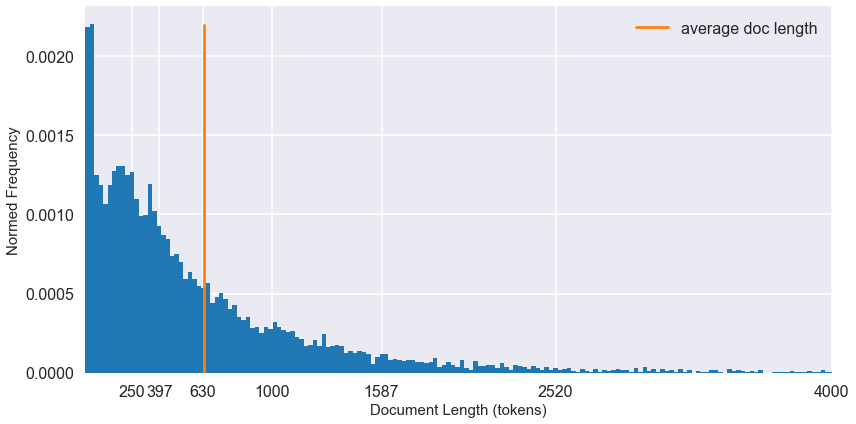

In [246]:
# plot a histogram of document length

num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
# ax.set_title(r'Frequency of eucildean distance between point pairs', fontsize=20)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(250),stop=np.log10(4000),num=7, base=10.0))
plt.xlim(0,4000)

ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0022,100)], np.linspace(0.0,0.0022,100), '-',
        label='average doc length')

ax.legend()
ax.grid()

fig.tight_layout()
plt.show()

In [247]:
def include_top_k_words(text):
    new_text = []
    for sent in text:
        temp = [word for word in sent if word in top_k_words if len(word)>1]
        new_text.append(temp)
    return new_text

In [248]:
df['sent_tokenized_text'] = df['sent_tokenized_text'].apply(include_top_k_words)
df.head(10)

,uuid,author,title,text,language,site_url,country,sent_tokenized_text
0,0e611ace89a6a50b07cd587778dde1855601e8f0,J.E. Dyer,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",english,libertyunyielding.com,US,"[[print, ed], [coming, soon, to, oh, wait], [i..."
1,58016c4fc9091b1b0b6711620f775c95e9d834a7,BareNakedIslam,"MILO at Dartmouth College on Donald Trump, rea...",Notify me of follow-up comments by email. Noti...,english,barenakedislam.com,US,"[[notify, me, of, followup, comments, by, emai..."
2,d6f4f47c9d3c7027a5be8ab54c202dbe6e89204b,NaN,"Julian Assange Isn’t Done With Hillary, Reveal...",\nI have been reporting for weeks now about th...,english,endingthefed.com,US,"[[have, been, reporting, for, weeks, now, abou..."
3,6c7c3b19f1fbadd026f6b18f7adb5fea7346e9b9,John Patriot,Re: Apostate Evangelicals Are Poised To Become...,"Print \nIf you look at the numbers, there is n...",english,freedomoutpost.com,US,"[[print, if, you, look, at, the, numbers, ther..."
4,d845bd12e98e968eab24ad0709ffa4714e0fd722,Daisy Luther,AG Lynch Told FBI Director Comey NOT To Go Pub...,"in: Government , Government Corruption , Sleut...",english,thesleuthjournal.com,US,"[[in, government, government, corruption, sleu..."
5,5f3bc4d12d0b7c521d79d80120d7b2c7965655b8,NaN,"Racists, Misogynists and Homophobes all absolu...",Wednesday 9 November 2016 by Lucas Wilde Racis...,english,newsthump.com,US,"[[wednesday, november, by, lucas, wilde, racis..."
6,1b1dae3da4bcbdc57afad22e20d8bed710778b68,Alex Ansary,Russia Unveils Update of Advanced Nuclear Weapon,Russia Unveils Update of Advanced Nuclear Weap...,english,amtvmedia.com,US,"[[russia, unveils, update, of, advanced, nucle..."
7,b5fd0cb3f5c6583a9ab419f8b5d39f9e04ba4055,admin,Dying out: Wild animal numbers could fall by 6...,"RT October 27, 2016 \nThe number of wild anima...",english,prisonplanet.com,US,"[[rt, october, the, number, of, wild, animals,..."
8,8c66a0c14681e6a1b1df05febee0df40e0b656f5,MeThePeople,Comment on Trump’s Walk of Fame Star Vandalize...,"Posted on October 27, 2016 by DCG | 14 Comment...",english,fellowshipoftheminds.com,US,"[[posted, on, october, by, dcg, comments, libe..."
9,14c98af2e0cd4e468b1697acb27a6e78d5c9c5a4,The Doc,Regret Ever Buying Gold and Silver? AGXIIK Has...,Tweet Home » Gold » Gold News » Regret Ever Bu...,english,silverdoctors.com,US,"[[tweet, home, gold, gold, news, regret, ever,..."


In [249]:
all_sentences = list(df['sent_tokenized_text'])

In [250]:
all_sentences = [subitem for item in all_sentences for subitem in item]

In [251]:
all_sentences[0:3]

[['print', 'ed'],
 ['coming', 'soon', 'to', 'oh', 'wait'],
 ['its', 'already', 'here']]

In [136]:
token_count = sum([len(sentence) for sentence in all_sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 7,462,889 tokens


### * explain word2vec *

In [137]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

In [138]:
fake2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [139]:
fake2vec.build_vocab(all_sentences)

In [140]:
print("Word2Vec vocabulary length:", len(fake2vec.wv.vocab))

Word2Vec vocabulary length: 29974


In [141]:
# number of sentences
fake2vec.corpus_count

348219

In [143]:
fake2vec.train(all_sentences, total_examples=fake2vec.corpus_count, epochs=fake2vec.iter)

29550206

In [144]:
all_word_vectors_matrix = fake2vec.wv.syn0

In [145]:
all_word_vectors_matrix.shape

(29974, 300)

In [146]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
t1 = time.time()
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
t2 = time.time()
print("time to train TSNE on", all_word_vectors_matrix.shape[0], "word vectors:", (t2-t1)/60, "min")

time to train TSNE on 29974 word vectors: 21.3002161304156 min


In [147]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[fake2vec.wv.vocab[word].index])
            for word in fake2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [148]:
points.head(10)

,word,x,y
0,home,11.372158,1.713630
1,this,-9.261005,4.986228
2,month,29.558088,22.650064
3,popular,-32.898449,43.387966
4,are,-39.457912,24.597141
5,you,-1.146670,0.722413
6,on,10.091872,3.363739
7,pace,27.289373,26.511400
8,to,-8.349043,14.095357
9,reach,22.033085,26.339628


In [210]:
sns.set_context("poster")

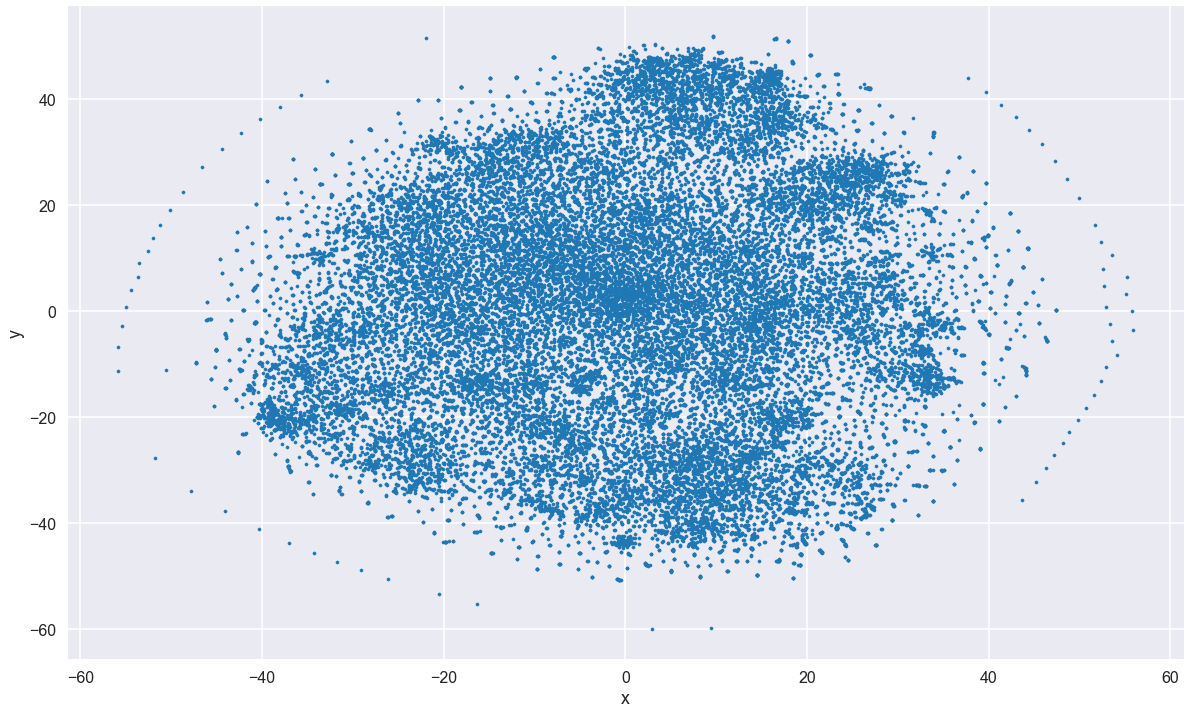

In [229]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [230]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

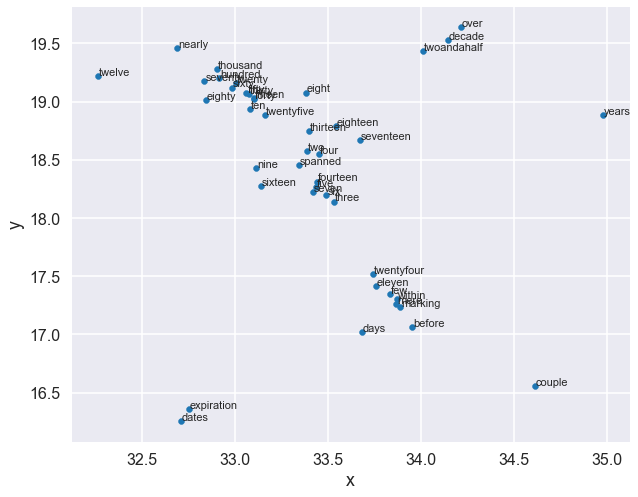

In [231]:
# numbers
plot_region((32,35), (15,20))

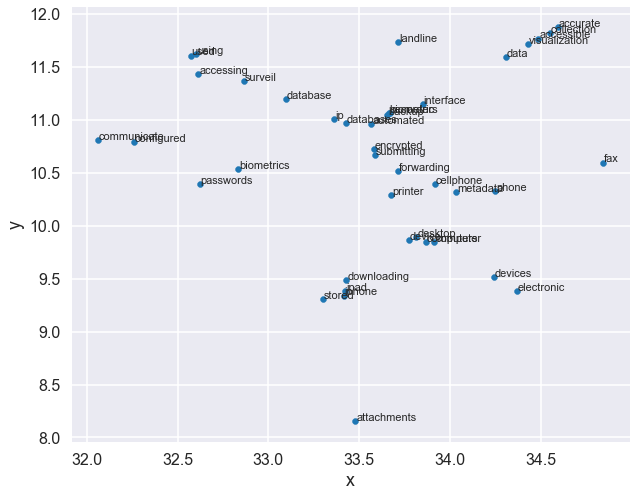

In [232]:
# IT
plot_region((31.8,35), (8,12))

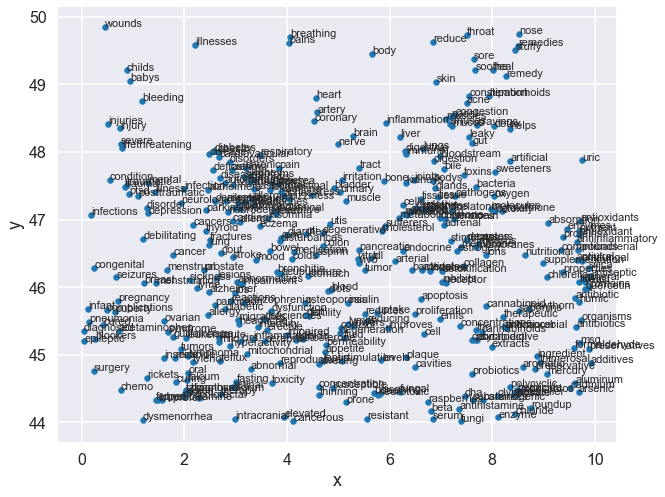

In [233]:
# medical issues
plot_region((0,10), (44,50))

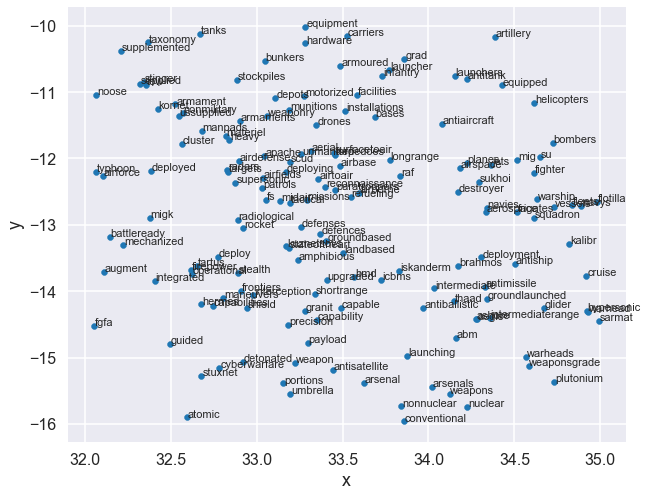

In [234]:
# military equipment
plot_region((32,35), (-16,-10))

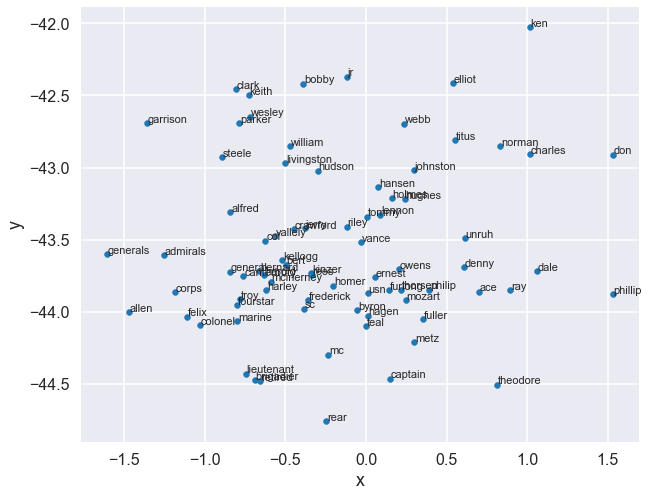

In [235]:
# names
plot_region((-2,2), (-45,-42))

In [176]:
fake2vec.most_similar('muslim')

[('brotherhood', 0.6151938438415527),
 ('freeloaders', 0.5662642121315002),
 ('somali', 0.5575268864631653),
 ('nonmuslim', 0.5547499656677246),
 ('invader', 0.5338033437728882),
 ('muslims', 0.5223865509033203),
 ('brotherhoods', 0.5216660499572754),
 ('holiest', 0.5069468021392822),
 ('nonmuslims', 0.5060951113700867),
 ('haram', 0.5052671432495117)]

In [177]:
fake2vec.most_similar('trump')

[('donald', 0.721954882144928),
 ('trumps', 0.6496169567108154),
 ('presumptive', 0.5685884952545166),
 ('yuge', 0.552943766117096),
 ('temperamentally', 0.5363315343856812),
 ('vitriol', 0.5353009104728699),
 ('donalds', 0.5340932607650757),
 ('presidentelect', 0.5289227962493896),
 ('reassuring', 0.5209646821022034),
 ('temperamental', 0.5147078037261963)]

In [198]:
fake2vec.most_similar('clinton')

[('clintons', 0.6707354187965393),
 ('hillary', 0.6540498733520508),
 ('rodham', 0.5577473640441895),
 ('hilary', 0.5527166128158569),
 ('robbie', 0.5321581363677979),
 ('killery', 0.5303435921669006),
 ('blumenthals', 0.5288667678833008),
 ('crooked', 0.5238121747970581),
 ('dogged', 0.5228588581085205),
 ('scandalridden', 0.5228548645973206)]

In [200]:
fake2vec.most_similar('january')

[('february', 0.6000413298606873),
 ('june', 0.5799887776374817),
 ('december', 0.576458752155304),
 ('august', 0.5603556632995605),
 ('jan', 0.5385704040527344),
 ('april', 0.5176163911819458),
 ('march', 0.5134395956993103),
 ('kigali', 0.486375629901886),
 ('september', 0.48035928606987),
 ('july', 0.47523948550224304)]